In [71]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#online

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.preprocessing import image_dataset_from_directory

img_size = 60
image_size = (img_size, img_size)

batch_size = 20

directory = 'drive/MyDrive/Photos/Working'
training_set = image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1303,
    image_size=image_size,
    batch_size=batch_size,
)

validation_set =image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1303,
    image_size=image_size,
    batch_size=batch_size,
)

test_set =image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = 'int',
    seed=1303,
    image_size=image_size,
    batch_size=545,
)


# #offline

# from tensorflow.keras.preprocessing import image_dataset_from_directory
# img_size = 150
# image_size = (img_size, img_size)

# batch_size = 5

# training_set = image_dataset_from_directory(
#     r'C:\Users\Admin\Pictures\FILM',
#     labels = "inferred",
#     label_mode = 'int',
#     validation_split=0.2,
#     subset="training",
#     seed=1303,
#     image_size=image_size,
#     batch_size=batch_size,
# )

# validation_set =image_dataset_from_directory(
#     r'C:\Users\Admin\Pictures\FILM',
#     labels = "inferred",
#     label_mode = 'int',
#     validation_split=0.2,
#     subset="validation",
#     seed=1303,
#     image_size=image_size,
#     batch_size=batch_size,
# )

# test_set =image_dataset_from_directory(
#     r'C:\Users\Admin\Pictures\FILM',
#     labels = "inferred",
#     label_mode = 'int',
#     seed=1303,
#     image_size=image_size,
#     batch_size=29,
# )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 307 files belonging to 4 classes.
Using 246 files for training.
Found 307 files belonging to 4 classes.
Using 61 files for validation.
Found 307 files belonging to 4 classes.


In [72]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [73]:
x_train = np.array([])
for x, y in training_set:
  x_train = np.concatenate([x])
  
x_test = np.array([])
for x, y in validation_set:
  x_test = np.concatenate([x])
  y_test = np.concatenate([y])

x_test_test = np.array([])
for x, y in test_set:
  x_test_test = np.concatenate([x])
  y_test_test = np.concatenate([y])

['Cath_fowerpics_2', 'Flowers', 'Other', 'Stones']


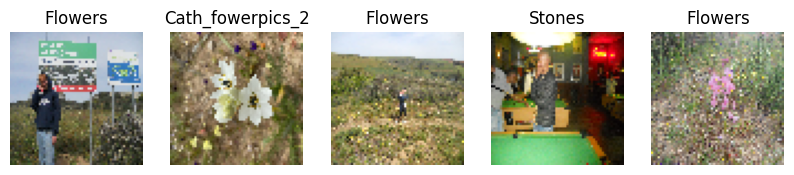

In [74]:
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(5):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [75]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### **Create the network**

In [76]:
# Define input shape and latent dimension
latent_dim = 1
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)

#magnitude
z_log_var_1 = Dense(latent_dim)(x)

#phase
upper = Dense(latent_dim)(x)
lower = Dense(latent_dim)(x)

In [77]:
from tensorflow.python.eager.context import anonymous_name
# Sampling function
def sampling_R(args):
    z_log_var = args
    sample = K.random_uniform(shape=(K.shape(z_log_var)[0], latent_dim))
    epsilon = K.sqrt(-2 * K.log(sample))
    return z_log_var * epsilon

def sampling_U(args):
    upper,lower = args
    sample = K.random_uniform(shape=(K.shape(upper)[0], latent_dim))
    return lower + (upper-lower)*sample

# Reparameterization trick
z1 = Lambda(sampling_R)(z_log_var_1)

# Reparameterization trick
z2 = Lambda(sampling_U)([upper,lower])


def complexreal(args):
    mag, phase = args
    x = mag*K.cos(phase)
    return x

def complexi(args):
    mag, phase = args
    y = mag*K.sin(phase)
    return y

z_complex_real = Lambda(complexreal)([z1,z2])
z_complex_i = Lambda(complexi)([z1,z2])
z_complex_concat = tf.keras.layers.Concatenate()([z_complex_real, z_complex_i])

# Define the VAE model
encoder = Model(inputs, [z_complex_real, z_complex_i, z_complex_concat,z1,z2], name='encoder')
#encoder.summary()


Decoder

In [78]:
# Decoder network
decoder_input = Input(K.int_shape(z_complex_concat)[1:])
#decoder_input = Input(K.int_shape(z1)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


Model

In [79]:
# Define the VAE model
encoder = Model(inputs, [z_complex_real, z_complex_i, z_complex_concat,z1,z2], name='encoder')
#encoder = Model(inputs, [z1, z_mean_m, z_log_var_m], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
#encoder.summary()
#decoder.summary()

Loss function

In [80]:
def kl_divergence_uniform(q):
    return K.sum(K.square(q - 0.5), axis=1)

# Define the VAE loss function

B = 100000
A = 100
C = 100

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2] *B


kl_loss_1 =(2*K.log(3/z_log_var_1) + (z_log_var_1*z_log_var_1 - 9)/9)*A
kl_loss_2 = (K.log(1/(upper - lower)) + ((upper - lower) /1) - 1)*C


vae_loss = K.mean(reconstruction_loss + kl_loss_1 + kl_loss_2)
vae.add_loss(vae_loss)

vae.add_metric(kl_loss_1, name="kl_loss_1")
vae.add_metric(kl_loss_2, name="kl_loss_2")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")

Training

In [81]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=400, batch_size=batch_size, validation_data=(x_test,None))
#vae.save('/content/drive/MyDrive/AI Models/RayUni')

Epoch 1/400
1/1 [==============================] - 7s 7s/step - loss: nan - kl_loss_1: nan - kl_loss_2: nan - reconstruction_loss: 78360464.0000 - val_loss: 146789824.0000 - val_kl_loss_1: 91.1857 - val_kl_loss_2: 517.7806 - val_reconstruction_loss: 146789216.0000
Epoch 2/400
1/1 [==============================] - 0s 74ms/step - loss: 78274512.0000 - kl_loss_1: 183.6727 - kl_loss_2: 311.8888 - reconstruction_loss: 78274016.0000 - val_loss: 147606320.0000 - val_kl_loss_1: 187.2684 - val_kl_loss_2: 2022.9235 - val_reconstruction_loss: 147604112.0000
Epoch 3/400
1/1 [==============================] - 0s 60ms/step - loss: 77986392.0000 - kl_loss_1: 43.6579 - kl_loss_2: 1360.2958 - reconstruction_loss: 77984992.0000 - val_loss: 153410720.0000 - val_kl_loss_1: 857.2777 - val_kl_loss_2: 1688.6051 - val_reconstruction_loss: 153408176.0000
Epoch 4/400
1/1 [==============================] - 0s 59ms/step - loss: 77617776.0000 - kl_loss_1: 372.7572 - kl_loss_2: 1180.2139 - reconstruction_loss: 776

Observing the latent space

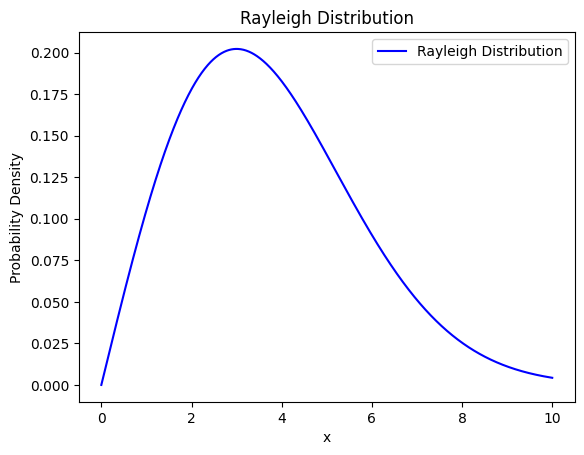

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Set the scale parameter (sigma) of the Rayleigh distribution
sigma = 3.0

# Generate values for the x-axis
x = np.linspace(0, 10, 1000)

# Compute the probability density function (PDF) of the Rayleigh distribution
pdf = (x / sigma**2) * np.exp(-x**2 / (2 * sigma**2))

# Plot the Rayleigh distribution
plt.plot(x, pdf, color='blue', label='Rayleigh Distribution')

# Add labels and title to the plot
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Rayleigh Distribution')

# Display the legend and show the plot
plt.legend()
plt.show()


10/10 [==============================] - 0s 6ms/step


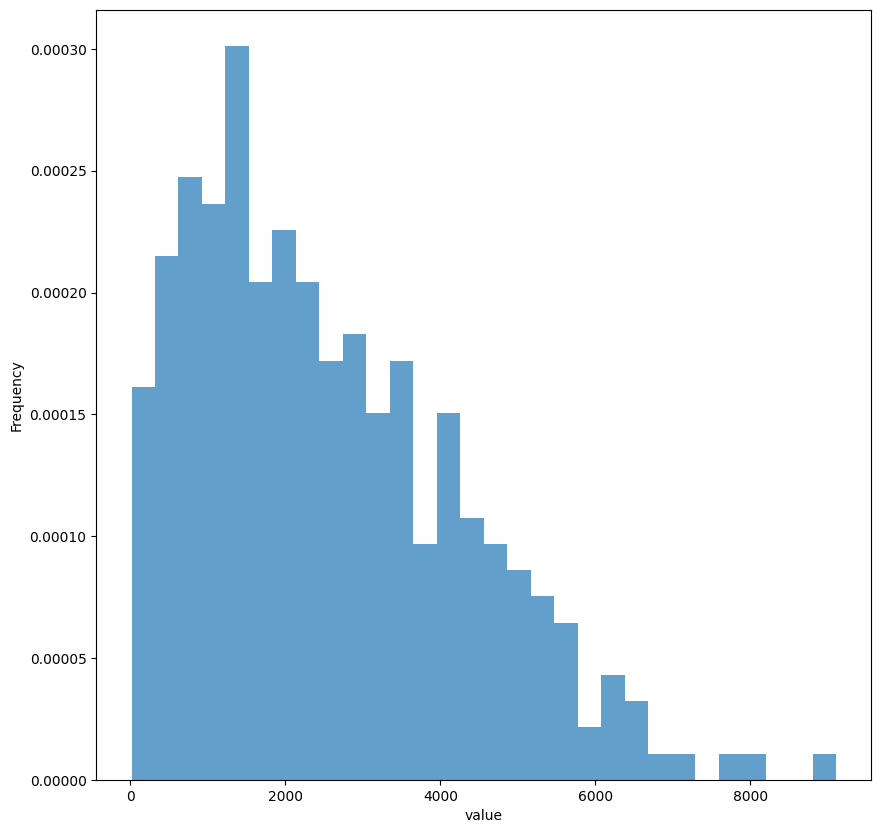

In [83]:
z_complex_real_out, z_complex_i_out, z_complex_concat_out,z1_out,z2_out = encoder.predict(x_test_test)
plt.figure(figsize=(10, 10))
plt.hist(z1_out[:, 0], bins=30, density=True, alpha=0.7)
plt.xlabel('value')
plt.ylabel('Frequency')
plt.show()

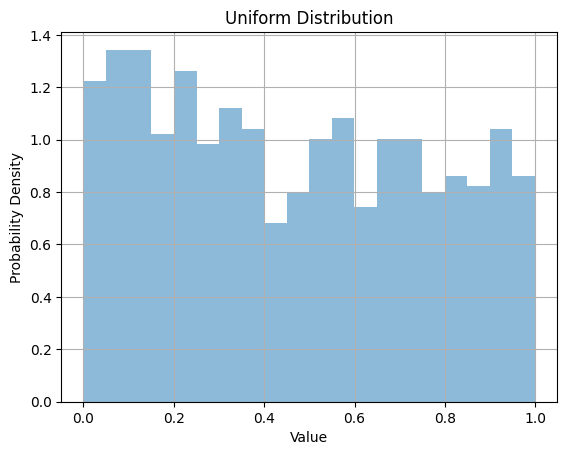

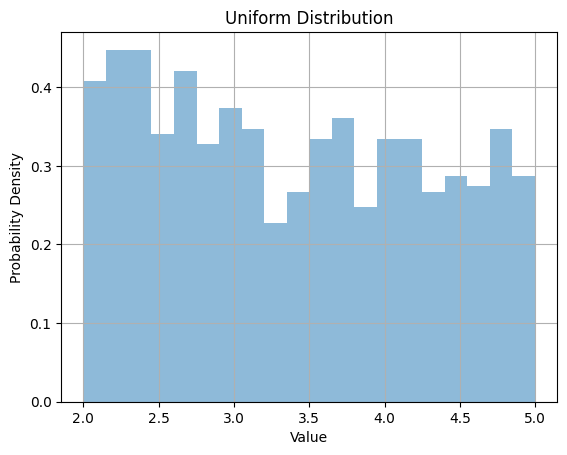

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of the uniform distribution
a = 0  # Lower bound
b = 1  # Upper bound

# Generate random samples from the uniform distribution
samples = np.random.uniform(low=a, high=b, size=1000)

# Plot the histogram of the samples
plt.hist(samples, bins=20, density=True, alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Uniform Distribution')
plt.grid(True)
plt.show()

# Define the desired scaled range
c = 2  # Lower bound of the scaled range
d = 5  # Upper bound of the scaled range

# Scale the uniform samples
scaled_samples = (d - c) * samples + c

# Plot the histogram of the samples
plt.hist(scaled_samples, bins=20, density=True, alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Uniform Distribution')
plt.grid(True)
plt.show()


10/10 [==============================] - 0s 5ms/step


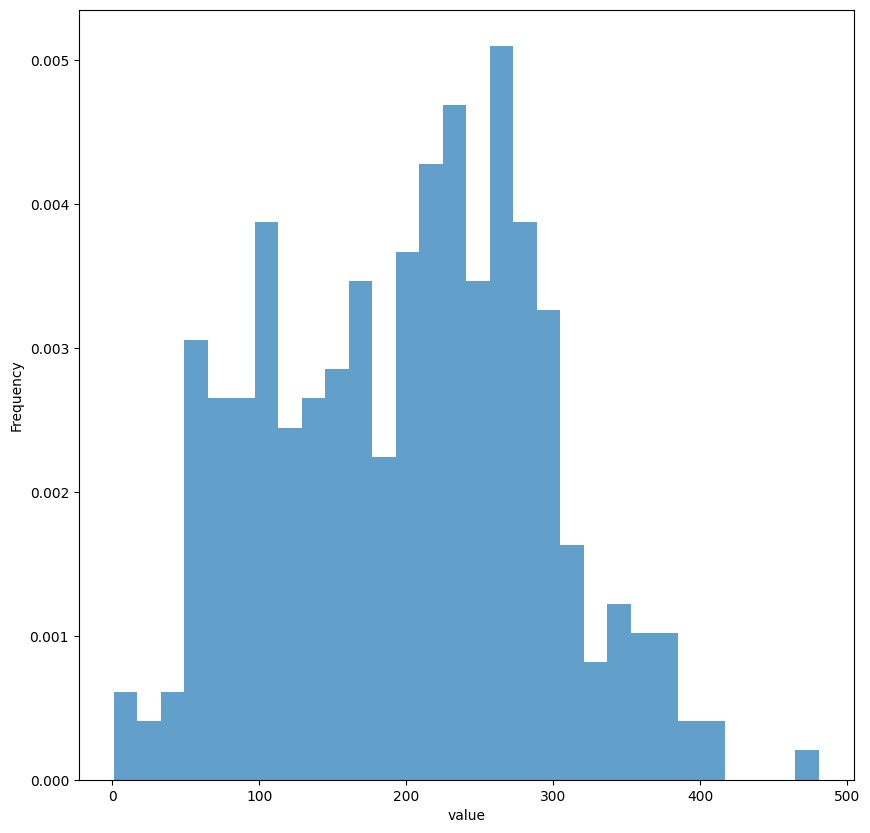

In [85]:
z_complex_real_out, z_complex_i_out, z_complex_concat_out ,z1_out,z2_out = encoder.predict(x_test_test)
plt.figure(figsize=(10, 10))
plt.hist(z2_out[:, 0], bins=30, density=True, alpha=0.7)
plt.xlabel('value')
plt.ylabel('Frequency')
plt.show()

Fitting Distributions

In [86]:
import matplotlib.pyplot as plt
# Convert the predictions into images
num_samples = 10
random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))

decoded_imgs = vae.predict(random_latent_vectors)
# Display the original and reconstructed images
n = 1 # number of images to display
plt.figure(figsize=(10, 10))



1/1 [==============================] - 0s 313ms/step


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

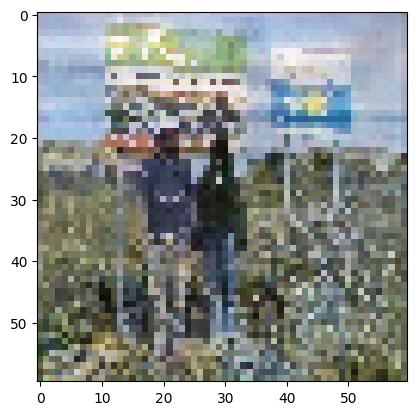

In [87]:
i = 2
plt.imshow(random_latent_vectors[i].reshape(img_size, img_size,3))
plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
plt.show()

In [103]:
n = 7
figure = np.zeros((img_size * n, img_size * n, 3))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space

start = -1
stop = +1

grid_x = np.linspace(start, stop, n)
grid_y = np.linspace(start, stop, n)[::-1]

print(grid_x)
print(grid_y)

testing = np.array([])

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi,yi]])
        x_decoded = decoder.predict(z_sample)
        if (i==0) & (j==0):
          testing = np.concatenate([x_decoded])
        else:
          temp = np.concatenate([x_decoded])
          testing = np.concatenate((testing,temp))

print(testing.shape)

[-1.         -0.66666667 -0.33333333  0.          0.33333333  0.66666667
  1.        ]
[ 1.          0.66666667  0.33333333  0.         -0.33333333 -0.66666667
 -1.        ]
1/1 [==============================] - 0s 19ms/step
(49, 60, 60, 3)


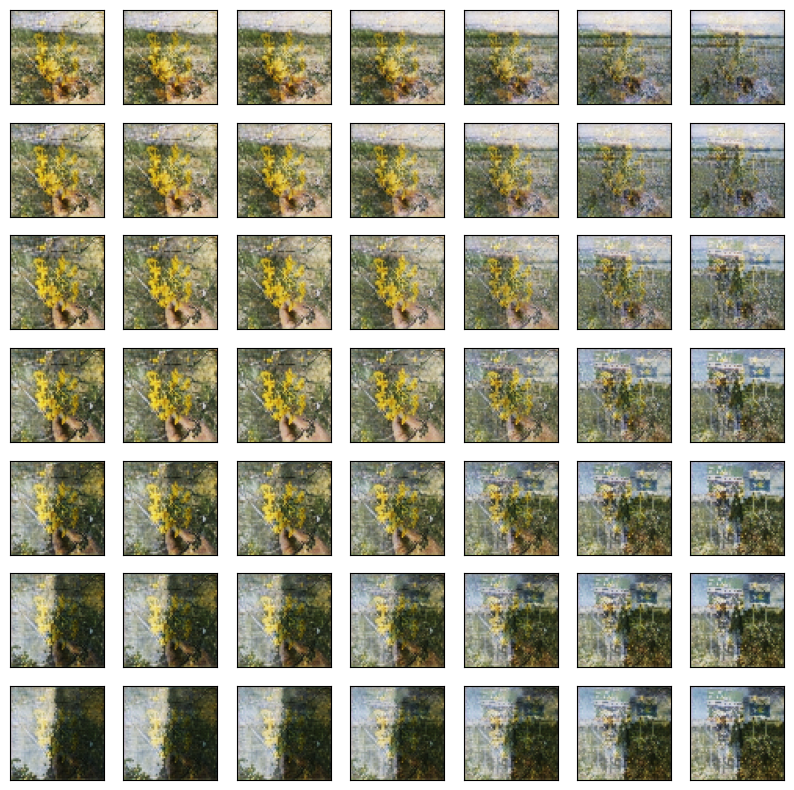

In [104]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n =  n*n
plt.figure(figsize=(10, 10))


for i in range(49):
    # Display the original image
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(testing[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()

1/1 [==============================] - 0s 35ms/step


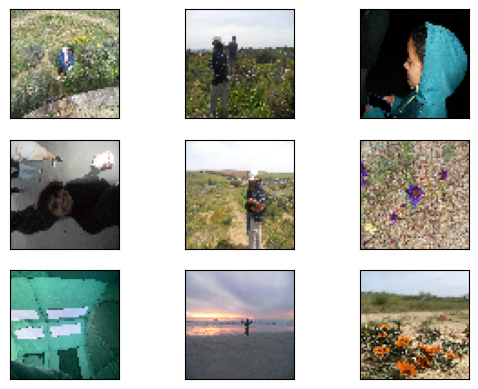

In [105]:
x = x_test_test[10:20]
lesttest = vae.predict(x)
for i in range(9):
    # Display the original image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].reshape(img_size, img_size,3).astype('uint8'))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

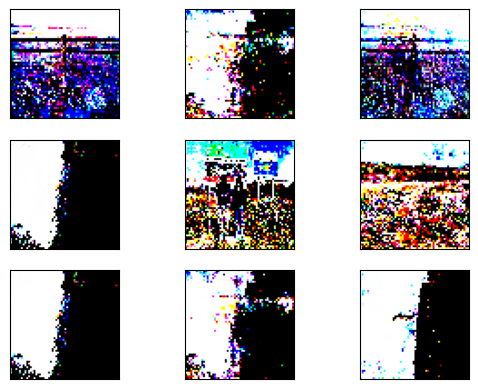

In [106]:
for i in range(9):
    # Display the original image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lesttest[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

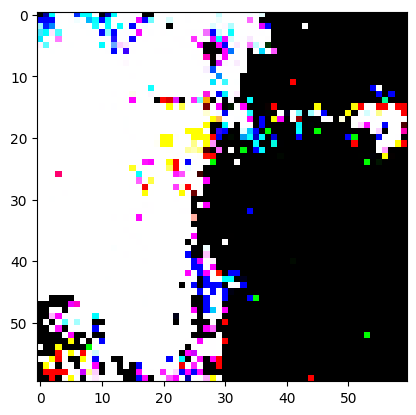

In [107]:
plt.imshow(lesttest[7].reshape(img_size, img_size,3))